# Trabalho final da Disciplina Aprendizagem de Máquina
# Aluno - Francisco Flávio Cardoso Gomes
# Predição de Série Tempora com redes neurais recorrentes LSTM em python com keras

In [378]:
from numpy import array

import numpy as np
import tensorflow as tf
import random as rn
import os
os.environ['PYTHONHASHSEED'] = '0'

#Fixar a semente do número aleatório para garantir que nossos resultados sejam reproduzíveis.
np.random.seed(37)
rn.seed(1254)
tf.random.set_seed(89)

from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
import tensorflow as tf
import matplotlib.pyplot as plt




In [379]:
import gzip
import shutil
import requests
import os
from os import listdir
from os.path import isfile,join,abspath

##Carregando os dados

In [380]:
url = 'https://data.brasil.io/dataset/covid19/caso_full.csv.gz'

In [381]:
def download_data():
    r = requests.get(url, allow_redirects=True)
    open('data.csv.gz', 'wb').write(r.content)

def unzip_data():
    with gzip.open('data.csv.gz', 'rb') as f_in:
        with open('data.csv', 'wb') as f_out:
            shutil.copyfileobj(f_in, f_out)
download_data()
unzip_data()

In [382]:
import pandas as pd

data = pd.read_csv('data.csv')
data=data[(data['state'] == 'CE') & data['city'].isna()]
data

,city,city_ibge_code,date,epidemiological_week,estimated_population,estimated_population_2019,is_last,is_repeated,last_available_confirmed,last_available_confirmed_per_100k_inhabitants,last_available_date,last_available_death_rate,last_available_deaths,order_for_place,place_type,state,new_confirmed,new_deaths
90461,NaN,23.0,2020-03-16,202012,9187103.0,9132078.0,False,False,9,0.09796,2020-03-16,0.0000,0,1,state,CE,9,0
90464,NaN,23.0,2020-03-17,202012,9187103.0,9132078.0,False,False,10,0.10885,2020-03-17,0.0000,0,2,state,CE,1,0
90468,NaN,23.0,2020-03-18,202012,9187103.0,9132078.0,False,False,19,0.20681,2020-03-18,0.0000,0,3,state,CE,9,0
90473,NaN,23.0,2020-03-19,202012,9187103.0,9132078.0,False,False,24,0.26124,2020-03-19,0.0000,0,4,state,CE,5,0
90480,NaN,23.0,2020-03-20,202012,9187103.0,9132078.0,False,False,68,0.74017,2020-03-20,0.0000,0,5,state,CE,44,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
148536,NaN,23.0,2021-02-24,202108,9187103.0,9132078.0,False,False,416790,4536.68583,2021-02-24,0.0266,11104,346,state,CE,2298,32
148722,NaN,23.0,2021-02-25,202108,9187103.0,9132078.0,False,False,420369,4575.64262,2021-02-25,0.0266,11184,347,state,CE,3579,80
148908,NaN,23.0,2021-02-26,202108,9187103.0,9132078.0,False,False,422782,4601.90770,2021-02-26,0.0266,11259,348,state,CE,2413,75
149094,NaN,23.0,2021-02-27,202108,9187103.0,9132078.0,False,False,424599,4621.68542,2021-02-27,0.0266,11280,349,state,CE,1817,21


##Renomeando as colunas que serão utilizadas

In [383]:
data = data.rename(columns={'last_available_confirmed': 'N. de Casos'})
data = data.rename(columns={'last_available_deaths': 'N. de Mortes'})
data = data.rename(columns={'new_confirmed': 'Novos Casos'})
data = data.rename(columns={'last_available_confirmed_per_100k_inhabitants':'%100K confirmados'})



In [384]:
casos=data['N. de Casos']
mortes = data['N. de Mortes']
novos = data['Novos Casos']
cemk=data['%100K confirmados']

In [385]:
type(casos)
casos = casos.tolist()
#mortes = mortes.tolist()
print(casos)

[9, 10, 19, 24, 68, 84, 125, 164, 185, 211, 237, 282, 322, 359, 382, 401, 445, 563, 658, 745, 960, 1045, 1188, 1394, 1445, 1558, 1668, 1747, 1935, 2070, 2291, 2412, 2747, 3062, 3306, 3485, 3682, 4116, 4702, 5121, 5667, 6260, 6783, 6985, 7409, 7861, 8000, 8309, 8379, 11040, 11470, 12310, 13888, 15134, 15879, 16692, 17599, 18412, 19156, 21077, 23059, 23795, 24255, 26363, 28112, 30560, 31413, 34573, 35122, 35595, 36185, 37021, 37275, 37821, 38395, 47822, 48489, 50504, 54683, 56056, 59795, 62176, 63575, 64271, 66218, 69023, 71947, 74692, 75784, 76429, 76833, 79853, 82169, 85606, 88132, 90441, 92397, 92866, 94708, 98055, 99578, 103118, 105270, 107064, 107593, 108225, 110483, 114038, 116519, 118311, 121464, 121986, 123394, 126142, 129598, 131324, 134610, 136001, 136790, 137234, 139437, 141832, 144058, 146064, 146972, 147378, 147818, 151072, 154381, 156265, 159953, 161844, 162086, 162429, 165703, 169138, 171565, 174662, 176371, 176773, 176972, 179976, 182453, 184100, 186563, 188289, 188638, 1

###Análise Exploratória

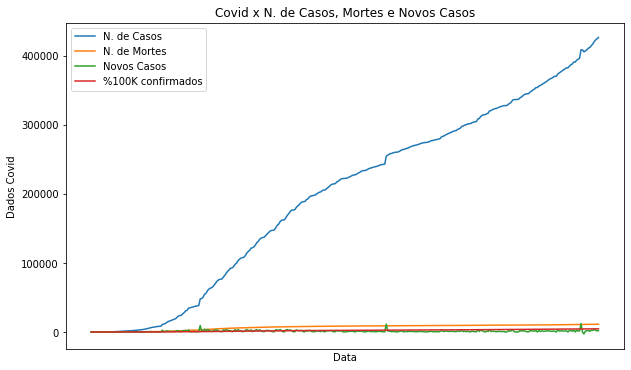

In [386]:
plt.figure(figsize=(10,6))
plt.plot(data['date'],data[['N. de Casos']],label='N. de Casos')
plt.plot(data['date'],data[['N. de Mortes']],label='N. de Mortes')
plt.plot(data['date'],data[['Novos Casos']],label='Novos Casos')
plt.plot(data['date'],data[['%100K confirmados']],label='%100K confirmados')
plt.xlabel("Data")
plt.ylabel('Dados Covid')
plt.legend(loc='upper left')
plt.title('Covid x N. de Casos, Mortes e Novos Casos')
plt.xticks([])
plt.show();

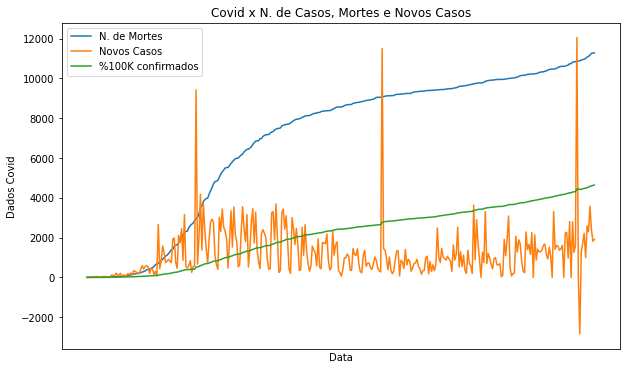

In [387]:
plt.figure(figsize=(10,6))
#plt.plot(data['date'],data[['N. de Casos']],label='N. de Casos')
plt.plot(data['date'],data[['N. de Mortes']],label='N. de Mortes')
plt.plot(data['date'],data[['Novos Casos']],label='Novos Casos')
plt.plot(data['date'],data[['%100K confirmados']],label='%100K confirmados')
plt.xlabel("Data")
plt.ylabel('Dados Covid')
plt.legend(loc='upper left')
plt.title('Covid x N. de Casos, Mortes e Novos Casos')
plt.xticks([])
plt.show();

###Podemos expressar o problema como um problema de regressão.
###Ou seja, dado o número de casos de covid em um período, qual é o número de casos no próximo período?

###Podemos escrever uma função simples para converter nossa única coluna de dados em um conjunto de dados de duas colunas: a primeira coluna contendo a contagem de casos deste período e a segunda coluna contendo a contagem de casos do próximo período, a ser prevista.

###função leva dois argumentos: o conjunto de dados , que é uma matriz NumPy que queremos converter em um conjunto de dados, e o número de passos , que é o número de etapas de tempo anteriores a serem usadas como variáveis ​​de entrada para prever o próximo período de tempo.

###Esse padrão criará um conjunto de dados onde X é o número de casos em um determinado momento (t) e Y é o número de passageiros no próximo momento (t + 1)



In [388]:
def split_sequence(sequence, passos):
    X, y = list(), list()
    for i in range(len(sequence)):
        fim = i + passos
        if(fim > len(sequence)-1):
            break
        seq_x, seq_y = sequence[i:fim], sequence[fim]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

In [389]:
passos=7
epocas=80

In [390]:
X,y = split_sequence(casos,passos)

In [391]:
print(X)

[[     9     10     19 ...     68     84    125]
 [    10     19     24 ...     84    125    164]
 [    19     24     68 ...    125    164    185]
 ...
 [406973 408692 410907 ... 414492 416790 420369]
 [408692 410907 411904 ... 416790 420369 422782]
 [410907 411904 414492 ... 420369 422782 424599]]


###A rede LSTM espera que os dados de entrada (X) sejam fornecidos com uma estrutura de array específica na forma de: [amostras, intervalos de tempo, features].

###Atualmente, nossos dados estão no formato: [ amostras, features ] e estamos enquadrando o problema como n epocas de tempo para cada amostra. Podemos transformar os dados na estrutura esperada usando numpy.reshape () da seguinte maneira:


In [392]:
n_features = 1
X = X.reshape((X.shape[0], X.shape[1],n_features))

In [393]:
print(X)

[[[     9]
  [    10]
  [    19]
  ...
  [    68]
  [    84]
  [   125]]

 [[    10]
  [    19]
  [    24]
  ...
  [    84]
  [   125]
  [   164]]

 [[    19]
  [    24]
  [    68]
  ...
  [   125]
  [   164]
  [   185]]

 ...

 [[406973]
  [408692]
  [410907]
  ...
  [414492]
  [416790]
  [420369]]

 [[408692]
  [410907]
  [411904]
  ...
  [416790]
  [420369]
  [422782]]

 [[410907]
  [411904]
  [414492]
  ...
  [420369]
  [422782]
  [424599]]]


###Agora estamos prontos para criar nossa rede LSTM

In [394]:

model = tf.keras.models.Sequential()
model.add(LSTM(100, activation='relu',input_shape=(passos,n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse', metrics=['mse'])

res1=pd.DataFrame(columns=['features','predito','real','diferença'])
res2=pd.DataFrame(columns=['features','predito','real','diferença'])


In [395]:
model.fit(X,y,epochs=epocas)

Epoch 1/80
11/11 [==============================] - 1s 7ms/step - loss: 32492516181.3333 - mse: 32492516181.3333
Epoch 2/80
11/11 [==============================] - 0s 7ms/step - loss: 13017020074.6667 - mse: 13017020074.6667
Epoch 3/80
11/11 [==============================] - 0s 7ms/step - loss: 3524227285.3333 - mse: 3524227285.3333
Epoch 4/80
11/11 [==============================] - 0s 7ms/step - loss: 3327996309.3333 - mse: 3327996309.3333
Epoch 5/80
11/11 [==============================] - 0s 7ms/step - loss: 190150884.0000 - mse: 190150884.0000
Epoch 6/80
11/11 [==============================] - 0s 7ms/step - loss: 1389032606.6667 - mse: 1389032606.6667
Epoch 7/80
11/11 [==============================] - 0s 7ms/step - loss: 293902802.0000 - mse: 293902802.0000
Epoch 8/80
11/11 [==============================] - 0s 7ms/step - loss: 3522576997.3333 - mse: 3522576997.3333
Epoch 9/80
11/11 [==============================] - 0s 7ms/step - loss: 4136130645.3333 - mse: 4136130645.3333
E

###Fazendo 2 Predições 

In [396]:
prox=X[100]
yprox=X[101][passos-1]
yprox=yprox[0]
prox = prox.reshape((1,passos,n_features))
pred=model.predict(prox)
print('Valor predito:{}, Valor real:{}, Dif: {}'.format(pred,yprox,yprox-pred))
res1=res1.append({'features':'Casos','predito':pred,'real':yprox,'diferença':pred-yprox},ignore_index=True)


Valor predito:[[106783.34]], Valor real:114038, Dif: [[7254.65625]]


In [397]:
prox=X[101]
yprox=X[102][passos-1]
yprox=yprox[0]
prox = prox.reshape((1,passos,n_features))
pred=model.predict(prox)
print('Valor predito:{}, Valor real:{}, Dif: {}'.format(pred,yprox,yprox-pred))
res2=res2.append({'features':'Caso','predito':pred,'real':yprox,'diferença':pred-yprox},ignore_index=True)


Valor predito:[[108828.375]], Valor real:116519, Dif: [[7690.625]]


##Inserir um segundo Parâmetro (numeral 1)

In [398]:
ones = [1 for i in range(len(casos))]
print(ones)


[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

In [399]:

# Inserindo o numero 1 na lista seq(casos)
res = [] 
for idx in range(0, len(casos)): 
    res.append(casos[idx]) 
    res.append(ones[idx]) 
  
# printing result 
print(res)


[9, 1, 10, 1, 19, 1, 24, 1, 68, 1, 84, 1, 125, 1, 164, 1, 185, 1, 211, 1, 237, 1, 282, 1, 322, 1, 359, 1, 382, 1, 401, 1, 445, 1, 563, 1, 658, 1, 745, 1, 960, 1, 1045, 1, 1188, 1, 1394, 1, 1445, 1, 1558, 1, 1668, 1, 1747, 1, 1935, 1, 2070, 1, 2291, 1, 2412, 1, 2747, 1, 3062, 1, 3306, 1, 3485, 1, 3682, 1, 4116, 1, 4702, 1, 5121, 1, 5667, 1, 6260, 1, 6783, 1, 6985, 1, 7409, 1, 7861, 1, 8000, 1, 8309, 1, 8379, 1, 11040, 1, 11470, 1, 12310, 1, 13888, 1, 15134, 1, 15879, 1, 16692, 1, 17599, 1, 18412, 1, 19156, 1, 21077, 1, 23059, 1, 23795, 1, 24255, 1, 26363, 1, 28112, 1, 30560, 1, 31413, 1, 34573, 1, 35122, 1, 35595, 1, 36185, 1, 37021, 1, 37275, 1, 37821, 1, 38395, 1, 47822, 1, 48489, 1, 50504, 1, 54683, 1, 56056, 1, 59795, 1, 62176, 1, 63575, 1, 64271, 1, 66218, 1, 69023, 1, 71947, 1, 74692, 1, 75784, 1, 76429, 1, 76833, 1, 79853, 1, 82169, 1, 85606, 1, 88132, 1, 90441, 1, 92397, 1, 92866, 1, 94708, 1, 98055, 1, 99578, 1, 103118, 1, 105270, 1, 107064, 1, 107593, 1, 108225, 1, 110483, 1, 

In [400]:
##Transformando em duas dimensões
res = np.reshape(res, (-1, 2))
#print(casos)

In [401]:
print(len(res))

350


In [402]:
def split_sequence(sequence, passos):
    X, y = list(), list()
    for i in range(len(sequence)):
        fim = i + passos
        if(fim > len(sequence)-1):
            break
        seq_x, seq_y = sequence[i:fim], sequence[fim][0]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

In [403]:

X,y = split_sequence(res,passos)

In [404]:
n_features = 2
X = X.reshape((X.shape[0], X.shape[1],n_features))

In [405]:
model = tf.keras.models.Sequential()
model.add(LSTM(100, activation='relu',input_shape=(passos,n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse', metrics=['mse'])

In [406]:
model.fit(X,y,epochs=epocas)

Epoch 1/80
11/11 [==============================] - 1s 7ms/step - loss: 72218957141.3333 - mse: 72218957141.3333
Epoch 2/80
11/11 [==============================] - 0s 7ms/step - loss: 60485980842.6667 - mse: 60485980842.6667
Epoch 3/80
11/11 [==============================] - 0s 7ms/step - loss: 38572044458.6667 - mse: 38572044458.6667
Epoch 4/80
11/11 [==============================] - 0s 7ms/step - loss: 22218027008.0000 - mse: 22218027008.0000
Epoch 5/80
11/11 [==============================] - 0s 7ms/step - loss: 6067897903.0000 - mse: 6067897903.0000
Epoch 6/80
11/11 [==============================] - 0s 7ms/step - loss: 3227666389.3333 - mse: 3227666389.3333
Epoch 7/80
11/11 [==============================] - 0s 7ms/step - loss: 292083356.0000 - mse: 292083356.0000
Epoch 8/80
11/11 [==============================] - 0s 8ms/step - loss: 1231599008.0000 - mse: 1231599008.0000
Epoch 9/80
11/11 [==============================] - 0s 7ms/step - loss: 714593706.6667 - mse: 714593706.66

In [407]:

prox=X[100]
yprox=X[101][passos-1]
yprox=yprox[0]
prox = prox.reshape((1,passos,n_features))
pred=model.predict(prox)
print('Valor predito:{}, Valor real:{}, Dif: {}'.format(pred,yprox,yprox-pred))

res1=res1.append({'features':'Casos e numeral 1','predito':pred,'real':yprox,'diferença':pred-yprox},ignore_index=True)


Valor predito:[[107688.07]], Valor real:114038, Dif: [[6349.9296875]]


In [408]:
yprox-pred
prox=X[101]
yprox=X[102][passos-1] 
yprox=yprox[0]
prox = prox.reshape((1,passos,n_features))
pred=model.predict(prox)
print('Valor predito:{}, Valor real:{}, Dif: {}'.format(pred,yprox,yprox-pred))

res2=res2.append({'features':'Casos e numeral 1','predito':pred,'real':yprox,'diferença':pred-yprox},ignore_index=True)


Valor predito:[[109646.28]], Valor real:116519, Dif: [[6872.71875]]


##Inserir um segundo Parâmetro (Número de novos casos)

In [409]:
print (novos)


90461        9
90464        1
90468        9
90473        5
90480       44
          ... 
148536    2298
148722    3579
148908    2413
149094    1817
149280    1912
Name: Novos Casos, Length: 350, dtype: int64


In [410]:
novos = np.array(novos).tolist()
# Inserindo o numero de novos na lista de casos
res = [] 
for idx in range(0, len(casos)): 
    res.append(casos[idx]) 
    res.append(novos[idx]) 
  
# printing result 
print(res)



[9, 9, 10, 1, 19, 9, 24, 5, 68, 44, 84, 16, 125, 41, 164, 39, 185, 21, 211, 26, 237, 26, 282, 45, 322, 40, 359, 37, 382, 23, 401, 19, 445, 44, 563, 118, 658, 95, 745, 87, 960, 215, 1045, 85, 1188, 143, 1394, 206, 1445, 51, 1558, 113, 1668, 110, 1747, 79, 1935, 188, 2070, 135, 2291, 221, 2412, 121, 2747, 335, 3062, 315, 3306, 244, 3485, 179, 3682, 197, 4116, 434, 4702, 586, 5121, 419, 5667, 546, 6260, 593, 6783, 523, 6985, 202, 7409, 424, 7861, 452, 8000, 139, 8309, 309, 8379, 70, 11040, 2661, 11470, 430, 12310, 840, 13888, 1578, 15134, 1246, 15879, 745, 16692, 813, 17599, 907, 18412, 813, 19156, 744, 21077, 1921, 23059, 1982, 23795, 736, 24255, 460, 26363, 2108, 28112, 1749, 30560, 2448, 31413, 853, 34573, 3160, 35122, 549, 35595, 473, 36185, 590, 37021, 836, 37275, 254, 37821, 546, 38395, 574, 47822, 9427, 48489, 667, 50504, 2015, 54683, 4179, 56056, 1373, 59795, 3739, 62176, 2381, 63575, 1399, 64271, 696, 66218, 1947, 69023, 2805, 71947, 2924, 74692, 2745, 75784, 1092, 76429, 645, 76

In [411]:
##Transformando em duas dimensões
res = np.reshape(res, (-1, 2))
#print(res)

In [412]:

print(len(res))

350


In [413]:
def split_sequence(sequence, passos):
    X, y = list(), list()
    for i in range(len(sequence)):
        fim = i + passos
        if(fim > len(sequence)-1):
            break
        seq_x, seq_y = sequence[i:fim], sequence[fim][0]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

In [414]:
X,y = split_sequence(res,passos)

In [415]:
n_features = 2
X = X.reshape((X.shape[0], X.shape[1],n_features))


In [416]:
model.fit(X,y,epochs=epocas)

Epoch 1/80
11/11 [==============================] - 0s 8ms/step - loss: 27508766.0000 - mse: 27508766.0000
Epoch 2/80
11/11 [==============================] - 0s 7ms/step - loss: 190842416.0000 - mse: 190842416.0000
Epoch 3/80
11/11 [==============================] - 0s 7ms/step - loss: 226908400.0000 - mse: 226908400.0000
Epoch 4/80
11/11 [==============================] - 0s 8ms/step - loss: 81188424.0000 - mse: 81188424.0000
Epoch 5/80
11/11 [==============================] - 0s 8ms/step - loss: 27837300.0000 - mse: 27837300.0000
Epoch 6/80
11/11 [==============================] - 0s 8ms/step - loss: 18630952.0000 - mse: 18630952.0000
Epoch 7/80
11/11 [==============================] - 0s 9ms/step - loss: 16719397.0000 - mse: 16719397.0000
Epoch 8/80
11/11 [==============================] - 0s 8ms/step - loss: 8121006.0000 - mse: 8121006.0000
Epoch 9/80
11/11 [==============================] - 0s 9ms/step - loss: 6423753.0000 - mse: 6423753.5000
Epoch 10/80
11/11 [==================

In [417]:

prox=X[100]
yprox=X[101][passos-1]
yprox=yprox[0]
prox = prox.reshape((1,passos,n_features))
pred=model.predict(prox)
print('Valor predito:{}, Valor real:{}, Dif: {}'.format(pred,yprox,yprox-pred))

res1=res1.append({'features':'Casos e Novos Casos','predito':pred,'real':yprox,'diferença':pred-yprox},ignore_index=True)
res1



Valor predito:[[110761.68]], Valor real:114038, Dif: [[3276.3203125]]


,features,predito,real,diferença
0,Casos,[[106783.34]],114038,[[-7254.65625]]
1,Casos e numeral 1,[[107688.07]],114038,[[-6349.9296875]]
2,Casos e Novos Casos,[[110761.68]],114038,[[-3276.3203125]]


In [418]:
yprox-pred
prox=X[101]
yprox=X[102][passos-1]
yprox=yprox[0]
prox = prox.reshape((1,passos,n_features))
pred=model.predict(prox)
print('Valor predito:{}, Valor real:{}, Dif: {}'.format(pred,yprox,yprox-pred))

res2=res2.append({'features':'Casos e Novos Casos','predito':pred,'real':yprox,'diferença':pred-yprox},ignore_index=True)
res2

Valor predito:[[114047.055]], Valor real:116519, Dif: [[2471.9453125]]


,features,predito,real,diferença
0,Caso,[[108828.375]],116519,[[-7690.625]]
1,Casos e numeral 1,[[109646.28]],116519,[[-6872.71875]]
2,Casos e Novos Casos,[[114047.055]],116519,[[-2471.9453125]]


###Conclusão - O modelo melhora à media que acrescentamos novas features, como previsto.